In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt

## Load Data

### Motif Enrichment

In [5]:
motif_gene_anno = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/MotifClustering/JASPAR2020_CORE_vertebrates_non-redundant.mouse_genes.with_motif_group.199.csv', 
    index_col=0
)
tf_class = pd.read_csv('/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv')
tf_class.head()

,uid,GeneRawName,SuperClass,Class,Family,SubFamily,EnsemblID
0,1.1.1.1.1,c-Jun,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,ENSMUSG00000052684
1,1.1.1.1.2,JunB,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,"ENSMUSG00000052837,ENSMUSG00000052926"
2,1.1.1.1.3,JunD,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,ENSMUSG00000071076
3,1.1.1.2.1,NFE2,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,NFE2,ENSMUSG00000058794
4,1.1.1.2.2,NFE2L1,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,NFE2,ENSMUSG00000038615


In [6]:
for tf_col in ['Class', 'Family', 'SubFamily']:
    gene_class_map = {}
    for _, (class_name, genes) in tf_class[[tf_col, 'EnsemblID']].iterrows():
        if isinstance(genes, float):
            continue
        for gene in genes.split(','):
            gene_class_map[gene] = class_name
    
    motif_gene_anno[tf_col] = motif_gene_anno['gene_ids'].apply(lambda i: gene_class_map.get(i.split('.')[0], ''))
motif_gene_anno.head()

,motif_name,motif_genes,gene_ids,gene_names,motif_group,Class,Family,SubFamily
motif_uid,,,,,,,,
MA0006.1,Ahr::Arnt,"Ahr,Arnt","ENSMUSG00000019256.17,ENSMUSG00000015522.18","Ahr,Arnt",MotifGroup178,Basic helix-loop-helix factors (bHLH),PAS,PAS-AHR
MA0854.1,Alx1,Alx1,ENSMUSG00000036602.14,Alx1,MotifGroup3,Homeo domain factors,Paired-related HD,ALX
MA0634.1,ALX3,ALX3,ENSMUSG00000014603.3,Alx3,MotifGroup3,Homeo domain factors,Paired-related HD,TPRX
MA0853.1,Alx4,Alx4,ENSMUSG00000040310.12,Alx4,MotifGroup3,Homeo domain factors,Paired-related HD,ALX
MA0007.3,Ar,Ar,ENSMUSG00000046532.8,Ar,MotifGroup32,Nuclear receptors with C4 zinc fingers,Steroid hormone receptors,GR-like(NR3C)


In [7]:
lgp_cutoff = 6
odds_cutoff = 0.8

data = pd.read_msgpack('NodeMotifEnrichment.msg')
data = data[(data['-lgp'] > lgp_cutoff) & (data['log2odds'].abs() > odds_cutoff)].copy()
data = pd.concat([motif_gene_anno.reindex(data.index), data], axis=1)
data['SubFamily'] = data.apply(lambda i: i['SubFamily'] if isinstance(
    i['SubFamily'], str) else i['Family'],
                               axis=1)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Tree

In [8]:
linkage = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Exc.linkage.csv',
    index_col=0)
linkage_label = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Exc.linkage.orders.txt',
    header=None, index_col=0).index
dendro = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Exc.dendrogram.lib'
)

## Plot function

### Normal

In [9]:
import seaborn as sns
from matplotlib.cm import get_cmap
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
from scipy.cluster.hierarchy import dendrogram


def straight_branch(ax, a, b, plot_kws):
    """Draw link line between a and b"""
    a_x, ay = a
    bx, by = b
    branch_x = [a_x, bx, bx]
    branch_y = [ay, ay, by]
    if plot_kws is None:
        plot_kws = {}
    return ax.plot(branch_x, branch_y, **plot_kws)


def plot_dendrogram(linkage_df,
                    labels_list,
                    dendro_kws=None,
                    ax=None,
                    branch_type='straight',
                    plot_node_id=False,
                    plot_kws=None,
                    node_hue=None,
                    node_hue_norm=None,
                    palette='viridis',  # shared by both line and node hue
                    node_size=None,
                    node_size_norm=None,
                    line_hue=None,
                    line_hue_norm=None,
                    sizes=None,
                    size=30,
                    linewidth=1,
                    color=None):
    if plot_kws is None:
        plot_kws = {}

    _dendro_kws = dict(no_plot=True)
    if dendro_kws is not None:
        _dendro_kws.update(dendro_kws)
    # all we need is the leaves order from dendrogram,
    # bellow we recalculate the node position to match the node id,
    # so we can control each node
    dendro = dendrogram(linkage_df, labels=labels_list, **_dendro_kws)
    n_leaves = len(dendro['leaves'])

    node_pos = {}  # all node including singleton and non-singleton
    for leaf_x, leaf in enumerate(dendro['leaves']):
        node_pos[int(leaf)] = (leaf_x, 0)

    direct_link_map = {}  # node linkage, keys only contain non-singleton
    for i, (left, right, height, _) in linkage_df.iterrows():
        node_id = int(i + linkage_df.shape[0] + 1)
        left = int(left)
        right = int(right)
        node_x = (node_pos[left][0] + node_pos[right][0]) / 2
        node_pos[node_id] = [node_x, height]
        direct_link_map[node_id] = [int(left), int(right)]

    if branch_type == 'straight':
        branch_plot_function = straight_branch
    else:
        raise

    # node colors
    nan_color = '#D3D3D3' if color is None else color
    if node_hue is not None:
        if node_hue_norm is None:
            values = node_hue.values()
            _hue_norm = Normalize(vmin=min(values),
                                  vmax=max(values))
        else:
            _hue_norm = Normalize(vmin=min(node_hue_norm),
                                  vmax=max(node_hue_norm))
        _cmap = get_cmap(palette)

        def node_cmap(v):
            return (_cmap(_hue_norm(v)),)
    else:
        node_hue = {}

        def node_cmap(_):
            raise
    node_colors = {node: node_cmap(node_hue[node]) if (node in node_hue) else nan_color
                   for node in node_pos.keys()}

    # node sizes
    nan_size = size
    if node_size is not None:
        if sizes is None:
            nan_size = 10
            sizes = (10, 80)
        else:
            nan_size = sizes[0]

        if node_size_norm is None:
            values = node_size.values()
            _size_norm = Normalize(vmin=min(values),
                                   vmax=max(values))
        else:
            _size_norm = Normalize(vmin=min(node_size_norm),
                                   vmax=max(node_size_norm))

        def node_smap(v):
            v_norm = _size_norm(v)
            v_norm = min(1, max(0, v_norm)) # limit norm value to [0, 1]
            s = v_norm * (sizes[1] - sizes[0]) + sizes[0]
            return s
    else:
        node_size = {}

        def node_smap(_):
            raise
    node_sizes = {node: node_smap(node_size[node]) if (node in node_size) else nan_size
                  for node in node_pos.keys()}

    for node_id, (node_x, node_y) in node_pos.items():
        ax.scatter(node_x, node_y, s=node_sizes[node_id], c=node_colors[node_id], zorder=3)

    # line color
    nan_color = '#D3D3D3' if color is None else color
    if line_hue is not None:
        if line_hue_norm is None:
            values = line_hue.values()
            _hue_norm = Normalize(vmin=min(values),
                                  vmax=max(values))
        else:
            _hue_norm = Normalize(vmin=min(line_hue_norm),
                                  vmax=max(line_hue_norm))
        _cmap = get_cmap(palette)

        def line_cmap(v):
            return _cmap(_hue_norm(v))
    else:
        line_hue = {}

        def line_cmap(_):
            raise
    line_colors = {node: line_cmap(line_hue[node]) if (node in line_hue) else nan_color
                   for node in node_pos.keys()}

    ymax = 0
    for node_id, (node_x, node_y) in node_pos.items():
        ymax = max(ymax, node_y)
        # plot node id text
        if plot_node_id:
            if node_id >= n_leaves:
                ax.text(node_x, node_y, node_id,
                        fontsize=4 if 'fontsize' not in plot_kws else plot_kws['fontsize'],
                        ha='center', va='center', c='k')
            else:
                ax.text(node_x, -0.01, node_id,
                        fontsize=4 if 'fontsize' not in plot_kws else plot_kws['fontsize'],
                        ha='center', va='center', c='k')

        # plot branch
        # only non-singleton node has branch:
        if node_id in direct_link_map:
            # get child
            left_child, right_child = direct_link_map[node_id]

            # plot left branch
            branch_plot_function(ax, (node_x, node_y),
                                 node_pos[left_child],
                                 plot_kws=dict(c=line_colors[left_child],
                                               linewidth=linewidth))

            # plot right branch
            branch_plot_function(ax, (node_x, node_y),
                                 node_pos[right_child],
                                 plot_kws=dict(c=line_colors[right_child],
                                               linewidth=linewidth))

    ax.set_ylim(0 - ymax * 0.05, ymax * 1.05)
    return node_pos, dendro


def plot_parsimony_data(data, ax, hue_norm, palette):
    sns.barplot(data=data, x='index', y='tree',
                label='tree', ax=ax,
                color='steelblue', alpha=0.3)
    sns.scatterplot(data=data, x='index', y='raw',
                    label='raw', ax=ax, color='lightgray',
                    hue='tree', hue_norm=hue_norm, palette=palette,
                    alpha=0.7, linewidth=1, legend=None)
    return


def plot_colorbar(cax, cmap, cnorm, hue_norm, linewidth=0.5):
    if isinstance(cmap, str):
        cmap = get_cmap(cmap)

    colorbar = ColorbarBase(cax, cmap=cmap, norm=cnorm,
                            orientation='vertical', extend='both')
    colorbar_ticks = [hue_norm[0], sum(hue_norm) / 2, hue_norm[1]]
    # TODO automatic ticklabel format, auto sci-format, float trim etc
    colorbar_ticklabels = list(map(lambda i: f'{i:.1f}', colorbar_ticks))
    colorbar.set_ticks(colorbar_ticks)
    colorbar.set_ticklabels(colorbar_ticklabels)
    colorbar.outline.set_linewidth(linewidth)
    colorbar.ax.tick_params(size=1, pad=1, width=linewidth, length=0.3)
    return cax


### Polar

In [10]:
import seaborn as sns
from matplotlib.cm import get_cmap
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
from scipy.cluster.hierarchy import dendrogram
import numpy as np

def straight_branch_polar(ax, a, b, plot_kws):
    """Draw link line between a and b"""
    a_x, ay = a
    bx, by = b
    
    a_x = 2 * np.pi * a_x / 70
    bx = 2 * np.pi * bx / 70
    
    branch_x = [a_x, bx, bx]
    branch_y = [ay, ay, by]
    if plot_kws is None:
        plot_kws = {}
    return ax.plot(branch_x, branch_y, **plot_kws)


def plot_dendrogram_polar(linkage_df,
                    labels_list,
                    dendro_kws=None,
                    ax=None,
                    branch_type='straight',
                    plot_node_id=False,
                    plot_kws=None,
                    node_hue=None,
                    node_hue_norm=None,
                    palette='viridis',  # shared by both line and node hue
                    node_size=None,
                    node_size_norm=None,
                    line_hue=None,
                    line_hue_norm=None,
                    sizes=None,
                    size=30,
                    linewidth=1,
                    color=None):
    if plot_kws is None:
        plot_kws = {}

    _dendro_kws = dict(no_plot=True)
    if dendro_kws is not None:
        _dendro_kws.update(dendro_kws)
    # all we need is the leaves order from dendrogram,
    # bellow we recalculate the node position to match the node id,
    # so we can control each node
    dendro = dendrogram(linkage_df, labels=labels_list, **_dendro_kws)
    n_leaves = len(dendro['leaves'])

    node_pos = {}  # all node including singleton and non-singleton
    for leaf_x, leaf in enumerate(dendro['leaves']):
        node_pos[int(leaf)] = (leaf_x, 0)

    direct_link_map = {}  # node linkage, keys only contain non-singleton
    for i, (left, right, height, _) in linkage_df.iterrows():
        node_id = int(i + linkage_df.shape[0] + 1)
        left = int(left)
        right = int(right)
        node_x = (node_pos[left][0] + node_pos[right][0]) / 2
        node_pos[node_id] = [node_x, height]
        direct_link_map[node_id] = [int(left), int(right)]

    if branch_type == 'straight':
        branch_plot_function = straight_branch_polar
    else:
        raise

    # node colors
    nan_color = '#D3D3D3' if color is None else color
    if node_hue is not None:
        if node_hue_norm is None:
            values = node_hue.values()
            _hue_norm = Normalize(vmin=min(values),
                                  vmax=max(values))
        else:
            _hue_norm = Normalize(vmin=min(node_hue_norm),
                                  vmax=max(node_hue_norm))
        _cmap = get_cmap(palette)

        def node_cmap(v):
            return (_cmap(_hue_norm(v)),)
    else:
        node_hue = {}

        def node_cmap(_):
            raise
    node_colors = {node: node_cmap(node_hue[node]) if (node in node_hue) else nan_color
                   for node in node_pos.keys()}

    # node sizes
    nan_size = size
    if node_size is not None:
        if sizes is None:
            nan_size = 10
            sizes = (10, 80)
        else:
            nan_size = sizes[0]

        if node_size_norm is None:
            values = node_size.values()
            _size_norm = Normalize(vmin=min(values),
                                   vmax=max(values))
        else:
            _size_norm = Normalize(vmin=min(node_size_norm),
                                   vmax=max(node_size_norm))

        def node_smap(v):
            v_norm = _size_norm(v)
            v_norm = min(1, max(0, v_norm)) # limit norm value to [0, 1]
            s = v_norm * (sizes[1] - sizes[0]) + sizes[0]
            return s
    else:
        node_size = {}

        def node_smap(_):
            raise
    node_sizes = {node: node_smap(node_size[node]) if (node in node_size) else nan_size
                  for node in node_pos.keys()}

    for node_id, (node_x, node_y) in node_pos.items():
        node_x = 2 * np.pi * node_x / 70
        ax.scatter(node_x, node_y, s=node_sizes[node_id], c=node_colors[node_id], zorder=3)

    # line color
    nan_color = '#D3D3D3' if color is None else color
    if line_hue is not None:
        if line_hue_norm is None:
            values = line_hue.values()
            _hue_norm = Normalize(vmin=min(values),
                                  vmax=max(values))
        else:
            _hue_norm = Normalize(vmin=min(line_hue_norm),
                                  vmax=max(line_hue_norm))
        _cmap = get_cmap(palette)

        def line_cmap(v):
            return _cmap(_hue_norm(v))
    else:
        line_hue = {}

        def line_cmap(_):
            raise
    line_colors = {node: line_cmap(line_hue[node]) if (node in line_hue) else nan_color
                   for node in node_pos.keys()}

    ymax = 0
    for node_id, (node_x, node_y) in node_pos.items():
        ymax = max(ymax, node_y)
        # plot node id text
        if plot_node_id:
            _node_x = 2 * np.pi * node_x / 70
            if node_id >= n_leaves:
                ax.text(_node_x, node_y, node_id,
                        fontsize=4 if 'fontsize' not in plot_kws else plot_kws['fontsize'],
                        ha='center', va='center', c='k')
            else:
                ax.text(_node_x, -0.01, node_id,
                        fontsize=4 if 'fontsize' not in plot_kws else plot_kws['fontsize'],
                        ha='center', va='center', c='k')

        # plot branch
        # only non-singleton node has branch:
        if node_id in direct_link_map:
            # get child
            left_child, right_child = direct_link_map[node_id]

            # plot left branch
            branch_plot_function(ax, (node_x, node_y),
                                 node_pos[left_child],
                                 plot_kws=dict(c=line_colors[left_child],
                                               linewidth=linewidth))

            # plot right branch
            branch_plot_function(ax, (node_x, node_y),
                                 node_pos[right_child],
                                 plot_kws=dict(c=line_colors[right_child],
                                               linewidth=linewidth))

    ax.set_ylim(0 - ymax * 0.05, ymax * 1.05)
    print(n_leaves)
    return node_pos, dendro


def plot_parsimony_data(data, ax, hue_norm, palette):
    sns.barplot(data=data, x='index', y='tree',
                label='tree', ax=ax,
                color='steelblue', alpha=0.3)
    sns.scatterplot(data=data, x='index', y='raw',
                    label='raw', ax=ax, color='lightgray',
                    hue='tree', hue_norm=hue_norm, palette=palette,
                    alpha=0.7, linewidth=1, legend=None)
    return


def plot_colorbar(cax, cmap, cnorm, hue_norm, linewidth=0.5):
    if isinstance(cmap, str):
        cmap = get_cmap(cmap)

    colorbar = ColorbarBase(cax, cmap=cmap, norm=cnorm,
                            orientation='vertical', extend='both')
    colorbar_ticks = [hue_norm[0], sum(hue_norm) / 2, hue_norm[1]]
    # TODO automatic ticklabel format, auto sci-format, float trim etc
    colorbar_ticklabels = list(map(lambda i: f'{i:.1f}', colorbar_ticks))
    colorbar.set_ticks(colorbar_ticks)
    colorbar.set_ticklabels(colorbar_ticklabels)
    colorbar.outline.set_linewidth(linewidth)
    colorbar.ax.tick_params(size=1, pad=1, width=linewidth, length=0.3)
    return cax

## Plot

In [26]:
node_map = {
    node: {
        'l': int(left),
        'r': int(right)
    }
    for node, (left, right, *_) in linkage.iterrows()
}

node_hue = {}
#for node, sub_df in data[data['gene_names'] == 'Neurog2'].groupby(
for node, sub_df in data[data['SubFamily'] == 'Neurogenin-ATO'].groupby(
        'Node'):
    node = int(node)
    rep_data = sub_df.sort_values('-lgp').iloc[-1]
    color = rep_data['log2odds']
    child = node_map[node]['l'] if color > 0 else node_map[node]['r']
    node_hue[child] = abs(color)

In [27]:
sub_df

,motif_name,motif_genes,gene_ids,gene_names,motif_group,Class,Family,SubFamily,oddsratio,p_value,adj_p,-lgp,left_hit,left_no_hit,right_hit,right_no_hit,left_hit_rate,right_hit_rate,Node,log2odds
MA1109.1,NEUROD1,NEUROD1,ENSMUSG00000034701.9,Neurod1,MotifGroup5,Basic helix-loop-helix factors (bHLH),Tal-related,Neurogenin-ATO,2.531324,1.772401e-64,1.592946e-62,61.797799,2977.0,29814.0,308.0,7808.0,0.090787,0.037950,134,1.339892
MA1642.1,NEUROG2(var.2),NEUROG2,ENSMUSG00000027967.8,Neurog2,MotifGroup5,Basic helix-loop-helix factors (bHLH),Tal-related,Neurogenin-ATO,2.401511,1.060080e-90,2.540658e-88,87.595054,4695.0,28096.0,528.0,7588.0,0.143180,0.065057,134,1.263942


In [36]:
for a, b in data['gene_names'].value_counts().items():
    print(b, a, sep='\t')

16	Neurog2
14	Rora
12	Rfx1
12	Fosl2,Jun
12	Fosl1,Jun
11	Fosl2,Jund
11	Jun,Junb
11	Fos,Junb
11	Fosb,Junb
10	Junb
10	Fos,Jun
10	Fosl2,Junb
10	Smad2,Smad3
10	Fosl1,Junb
10	Fosl1
10	Neurod1
10	Jund
10	Shox2
10	Ptf1a
10	Fos
9	Bhlhe22
9	Atoh1
9	Rorc
9	Fosl2
9	Fos,Jund
9	Batf,Jun
9	Rfx3
9	Bhlhe23
9	Jdp2
9	Jun
9	Batf
9	Fosl1,Jund
8	Mef2a
8	Batf3
8	Bhlha15
8	Bach1
8	Olig2
8	Tal1,Tcf3
8	Olig1
8	Hand2
7	Neurod2
7	Olig3
6	Tcf21
6	Rorb
6	Nfe2
6	Pou6f1
6	Eomes
6	Neurog1
6	Lhx6
6	Mef2c
6	Tbx21
6	Tcf12
6	Pou3f1
5	Prrx1
5	Uncx
5	Hesx1
5	Pou3f3
5	Emx2
5	Lhx4
5	Pax4
5	Lhx9
5	Isx
5	Pou3f2
5	Pou2f2
5	Atoh7
4	Pou2f1
4	Lbx1
4	Vax1
4	Mef2b
4	Emx1
4	Lhx8
4	Mef2d
4	Gbx1
4	Pou3f4
4	Twist1
4	Msc
4	Vsx2
4	Dlx1
4	Hoxb5
4	Alx3
4	Nr4a1
4	Rax
4	Mixl1
4	Hoxa1
4	Rfx4
4	Prrx2
4	Tcf4
4	Vsx1
4	Hoxa2
4	Tbx20
4	Esx1
4	Nhlh1
3	Tfap4
3	Pdx1
3	Hoxb2
3	Tbx2
3	Lbx2
3	Dbp
3	Gbx2
3	Pou2f3
3	Lmx1a
3	Lmx1b
3	Tbx18
3	Nkx6-2
3	Pknox1
3	Myf5
3	Tfap2a
3	Evx1
3	Prrxl1
3	Phox2a
3	Meox1
3	Gsx1
3	Nfia
3	Tcf3
3	Pou1f1
3	En1
3	Rbpjl
3	Lhx5
3	M

In [29]:
sub_df

,motif_name,motif_genes,gene_ids,gene_names,motif_group,Class,Family,SubFamily,oddsratio,p_value,adj_p,-lgp,left_hit,left_no_hit,right_hit,right_no_hit,left_hit_rate,right_hit_rate,Node,log2odds
MA1109.1,NEUROD1,NEUROD1,ENSMUSG00000034701.9,Neurod1,MotifGroup5,Basic helix-loop-helix factors (bHLH),Tal-related,Neurogenin-ATO,2.531324,1.772401e-64,1.592946e-62,61.797799,2977.0,29814.0,308.0,7808.0,0.090787,0.037950,134,1.339892
MA1642.1,NEUROG2(var.2),NEUROG2,ENSMUSG00000027967.8,Neurog2,MotifGroup5,Basic helix-loop-helix factors (bHLH),Tal-related,Neurogenin-ATO,2.401511,1.060080e-90,2.540658e-88,87.595054,4695.0,28096.0,528.0,7588.0,0.143180,0.065057,134,1.263942


68


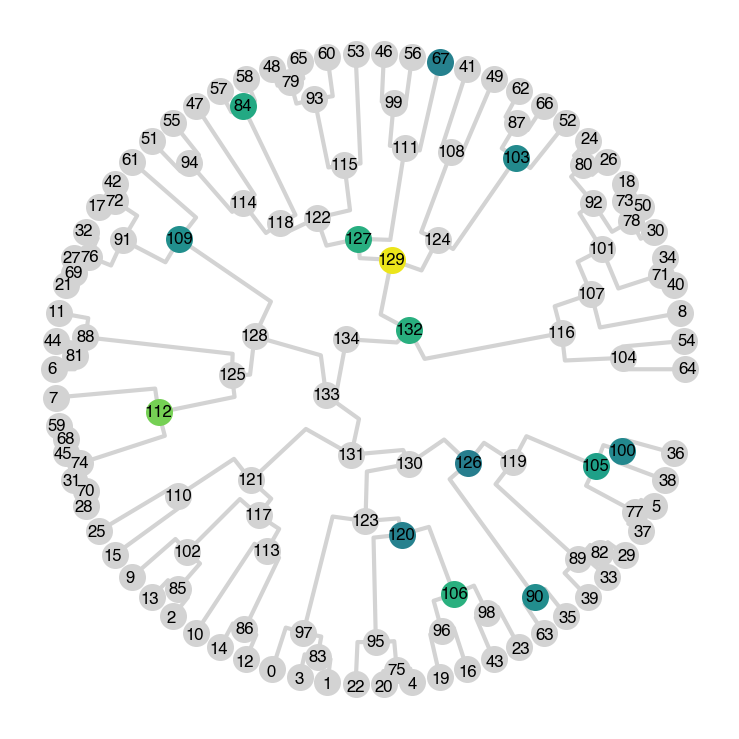

In [33]:
fig = plt.figure(figsize=(3, 3), dpi=300)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[:, :], projection='polar')

import matplotlib.transforms as mtransforms

trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,
                                       y=6, units='dots')

plot_dendrogram_polar(
    linkage.reset_index(drop=True),
    linkage_label,
    dendro_kws=None,
    ax=ax,
    branch_type='straight',
    plot_node_id=True,
    plot_kws=dict(transform=trans_offset),
    node_hue=node_hue,
    node_hue_norm=(0, 2),
    palette='viridis',  # shared by both line and node hue
    node_size=None,
    node_size_norm=None,
    line_hue=None,
    line_hue_norm=None,
    sizes=None,
    size=30,
    linewidth=1,
    color=None)
ax.set_rlim(1.3, -0.1)
ax.axis('off')
# r = 2 * np.random.rand(N)
# theta = 2 * np.pi * np.random.rand(N)
# 
# # sns.despine(ax=ax)
# ax.set(xticks=range(0, len(linkage_label)), xticklabels=linkage_label)
# ax.xaxis.set_tick_params(rotation=90)
pass

In [35]:
data[data['Class'] == 'Basic leucine zipper factors (bZIP)']

,motif_name,motif_genes,gene_ids,gene_names,motif_group,Class,Family,SubFamily,oddsratio,p_value,adj_p,-lgp,left_hit,left_no_hit,right_hit,right_no_hit,left_hit_rate,right_hit_rate,Node,log2odds
MA1142.1,FOSL1::JUND,"FOSL1,JUND","ENSMUSG00000024912.6,ENSMUSG00000071076.6","Fosl1,Jund",MotifGroup8,Basic leucine zipper factors (bZIP),Fos-related,Fos,0.413441,4.969232e-11,3.572878e-08,7.446982,64.0,1417.0,260.0,2380.0,0.043214,0.098485,74,-1.274246
MA0099.3,FOS::JUN,"FOS,JUN","ENSMUSG00000021250.13,ENSMUSG00000052684.4","Fos,Jun",MotifGroup8,Basic leucine zipper factors (bZIP),Fos-related,Fos,2.017358,1.090991e-11,8.715806e-10,9.059692,382.0,6079.0,116.0,3724.0,0.059124,0.030208,89,1.012467
MA0462.2,BATF::JUN,"BATF,JUN","ENSMUSG00000034266.6,ENSMUSG00000052684.4","Batf,Jun",MotifGroup8,Basic leucine zipper factors (bZIP),B-ATF-related,B-ATF-related,1.742250,1.464925e-12,2.106562e-10,9.676426,624.0,5837.0,222.0,3618.0,0.096579,0.057813,89,0.800952
MA0476.1,FOS,FOS,ENSMUSG00000021250.13,Fos,MotifGroup8,Basic leucine zipper factors (bZIP),Fos-related,Fos,1.857215,2.522039e-12,2.590494e-10,9.586617,506.0,5955.0,168.0,3672.0,0.078316,0.043750,89,0.893141
MA0477.2,FOSL1,FOSL1,ENSMUSG00000024912.6,Fosl1,MotifGroup8,Basic leucine zipper factors (bZIP),Fos-related,Fos,2.168059,9.530430e-10,4.030811e-08,7.394608,264.0,6197.0,74.0,3766.0,0.040861,0.019271,89,1.116404
MA0478.1,FOSL2,FOSL2,ENSMUSG00000029135.10,Fosl2,MotifGroup8,Basic leucine zipper factors (bZIP),Fos-related,Fos,1.854722,2.606458e-10,1.261209e-08,7.899213,409.0,6052.0,135.0,3705.0,0.063303,0.035156,89,0.891203
MA0490.2,JUNB,JUNB,ENSMUSG00000052837.6,Junb,MotifGroup8,Basic leucine zipper factors (bZIP),Jun-related,Jun,2.100532,2.631172e-10,1.261209e-08,7.899213,300.0,6161.0,87.0,3753.0,0.046432,0.022656,89,1.070755
MA0491.2,JUND,JUND,ENSMUSG00000071076.6,Jund,MotifGroup8,Basic leucine zipper factors (bZIP),Jun-related,Jun,2.445508,3.391823e-09,1.161296e-07,6.935057,194.0,6267.0,48.0,3792.0,0.030026,0.012500,89,1.290134
MA1128.1,FOSL1::JUN,"FOSL1,JUN","ENSMUSG00000024912.6,ENSMUSG00000052684.4","Fosl1,Jun",MotifGroup8,Basic leucine zipper factors (bZIP),Fos-related,Fos,2.288553,1.914990e-10,1.147398e-08,7.940286,256.0,6205.0,68.0,3772.0,0.039622,0.017708,89,1.194436
MA1130.1,FOSL2::JUN,"FOSL2,JUN","ENSMUSG00000029135.10,ENSMUSG00000052684.4","Fosl2,Jun",MotifGroup8,Basic leucine zipper factors (bZIP),Fos-related,Fos,1.993487,1.341594e-09,5.076875e-08,7.294404,311.0,6150.0,95.0,3745.0,0.048135,0.024740,89,0.995294
